<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/4_PyTorch_Avanzado/1_modelos_personalizados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
# Modelos Personalizados en Pytorch

## **Un bloque personalizado**

Funcionalidad básica de un bloque:

1. Ingerir datos de entrada como argumentos para su función de propagación directa.
1. Generar una salida haciendo que la función de propagación directa devuelva un valor. Tenga en cuenta que la salida puede tener una forma diferente a la entrada. Por ejemplo, la primera capa completamente conectada en nuestro modelo anterior ingiere una entrada de dimensión 20 pero devuelve una salida de dimensión 256.
1. Calcular el gradiente de su salida con respecto a su entrada, al que se puede acceder a través de su función de backpropagation. Por lo general, esto sucede automáticamente.
1. Almacenar y proporcionar acceso a aquellos parámetros necesarios para ejecutar el cálculo de propagación directa.
1. Inicializar los parámetros del modelo según sea necesario.


En el siguiente fragmento, codificamos un bloque desde cero
correspondiente a un MLP con una capa oculta con 256 unidades ocultas y una capa de salida de 10 dimensiones. Tenga en cuenta que la clase `MLP` a continuación hereda de la clase `Module` que representa un bloque. Confiaremos en gran medida en las funciones de la clase principal, proporcionando solo nuestro propio constructor (la función `__init__` en Python) y la función `forward` de propagación hacia adelante.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

# Definimos una clase llamada MLP que representa nuestro modelo neuronal.
# Esta clase hereda de nn.Module, que es la base de todos los bloques en PyTorch.
class MLP(nn.Module):

    # El método __init__ se ejecuta al crear una instancia del modelo.
    def __init__(self):
        # Llamamos al constructor de la clase base (nn.Module).
        # Esto es necesario para que PyTorch registre correctamente los parámetros del modelo.
        super().__init__()

        # Definimos una capa oculta totalmente conectada (densamente conectada).
        # Toma entradas de tamaño 20 y produce salidas de tamaño 256.
        self.hidden = nn.Linear(20, 256)

        # Definimos la capa de salida, que toma las 256 salidas de la capa oculta
        # y las convierte en 10 salidas (por ejemplo, para clasificación en 10 clases).
        self.out = nn.Linear(256, 10)

    # El método forward define cómo se procesan los datos a través del modelo.
    # Este método se llama automáticamente cuando haces `modelo(x)`.
    def forward(self, X):
        # Primero, pasamos la entrada por la capa oculta.
        # Luego aplicamos la función de activación ReLU para introducir no linealidad.
        # Finalmente, pasamos el resultado por la capa de salida.
        return self.out(F.relu(self.hidden(X)))

La función forward() dice cómo fluye la información en tu modelo.

Al usar self.hidden y self.out, cada red (net1, net2, etc.) tiene sus propios parámetros, así pueden entrenarse por separado.

super().__init__() es necesario para que PyTorch entienda tu modelo.

No necesitás escribir backpropagation manualmente. PyTorch lo hace por vos con .backward().


In [ ]:
net = MLP()
net(X)

tensor([[ 0.1298,  0.2597, -0.0968, -0.0494,  0.1476,  0.1454,  0.1632,  0.0199,
         -0.0087,  0.3480],
        [ 0.1466,  0.1623, -0.0858, -0.0544,  0.1312,  0.2089,  0.1057,  0.0484,
         -0.0889,  0.3298]], grad_fn=<AddmmBackward0>)

## **El Bloque Sequential**

Ahora podemos echar un vistazo más de cerca a cómo funciona la clase `Sequential`. Recuerde que `Sequential` fue diseñado para conectar en cadena otros bloques. Para construir nuestro propio `MySequential` simplificado, solo necesitamos definir dos funciones clave:
1. Una función para agregar bloques uno por uno a una lista.
2. Una función de propagación directa para pasar una entrada a través de la cadena de bloques, en el mismo orden en que se agregaron.

La siguiente clase `MySequential` ofrece la misma funcionalidad que la clase `Sequential` predeterminada.





In [ ]:
import torch
from torch import nn

# Esta clase personalizada actúa como una versión simple de nn.Sequential.
class MySequential(nn.Module):

    # El constructor recibe una cantidad variable de argumentos (capas).
    def __init__(self, *args):
        super().__init__()  # Inicializamos la clase base nn.Module

        # Recorremos todas las capas pasadas como argumento
        for idx, module in enumerate(args):
            # Cada módulo (capa) se guarda en self._modules, un OrderedDict interno de nn.Module
            # Le asignamos como clave un string del índice, ej: "0", "1", etc.
            self._modules[str(idx)] = module

    # La función forward define cómo fluye la información por los módulos secuenciales
    def forward(self, X):
        # Recorremos las capas en el orden en que fueron agregadas
        for block in self._modules.values():
            X = block(X)  # Aplicamos cada bloque (capa) al input
        return X  # Devolvemos la salida final


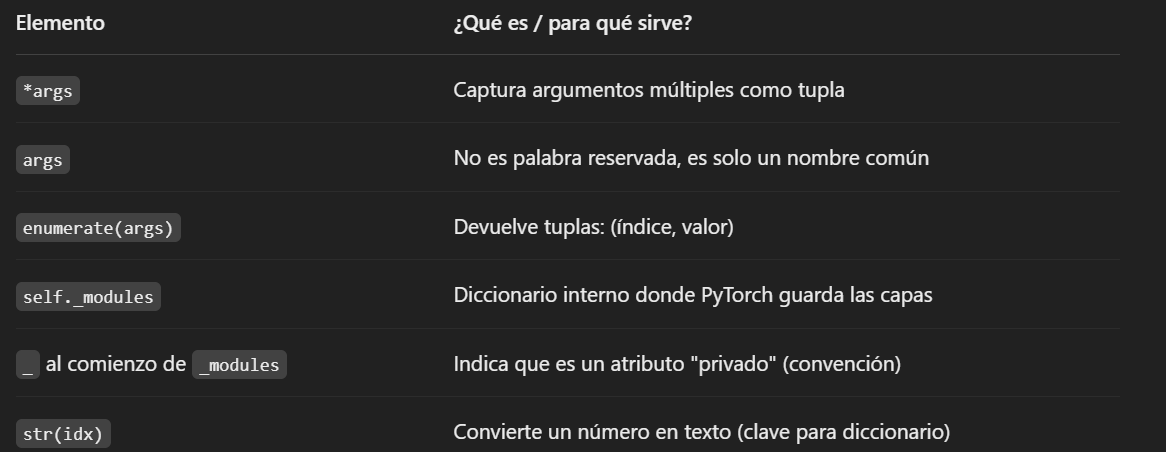

En el método `__init__`, agregamos cada bloque al diccionario ordenado `_modules` uno por uno. Quizás se pregunte por qué cada `Module` posee un atributo `_modules` y por qué lo usamos en lugar de simplemente definir una lista de Python nosotros mismos. En resumen, la principal ventaja de `_modules` es que durante la inicialización de los parámetros de nuestro bloque, el sistema sabe buscar dentro del diccionario `_modules` para encontrar subbloques cuyos parámetros también necesitan inicializarse.


Cuando se invoca la función de propagación directa de `MySequential`, cada bloque agregado se ejecuta en el orden en que se agregaron. Ahora podemos volver a implementar un MLP usando nuestra clase `MySequential`.


In [ ]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.2045, -0.1206,  0.2077,  0.0615, -0.1246,  0.0457, -0.0679, -0.3117,
          0.0269, -0.3475],
        [-0.2765, -0.2260,  0.1733,  0.1343, -0.3023,  0.0324, -0.1404, -0.4459,
         -0.0769, -0.2924]], grad_fn=<AddmmBackward0>)

Tenga en cuenta que este uso de `MySequential` es idéntico al código que escribimos anteriormente para la clase `Sequential`.

## **Ejecutando código en la función de propagación directa**



In [ ]:
# Definimos una clase personalizada de red neuronal, heredando de nn.Module
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base (nn.Module)
        super().__init__()

        # Creamos una matriz de pesos aleatorios de tamaño (20x20)
        # Estos NO se actualizarán durante el entrenamiento porque no requieren gradiente
        self.rand_weight = torch.rand((20, 20), requires_grad=False)

        # Definimos una capa lineal (completamente conectada) que transforma
        # un vector de tamaño 20 en otro vector de tamaño 20
        self.linear = nn.Linear(20, 20)

    # Esta es la función de propagación hacia adelante (forward)
    def forward(self, X):
        # Aplicamos la capa lineal al input X
        X = self.linear(X)

        # Multiplicamos el resultado por la matriz de pesos fija (no entrenable)
        # Le sumamos 1 a todos los elementos y aplicamos la función ReLU
        # - torch.mm: multiplicación de matrices
        # - F.relu: aplica la función ReLU (activa solo valores positivos)
        X = F.relu(torch.mm(X, self.rand_weight) + 1)

        # Volvemos a aplicar la misma capa lineal que usamos al principio
        # Esto implica que estamos reutilizando (compartiendo) los mismos pesos
        X = self.linear(X)

        # Ciclo de control: mientras la suma de los valores absolutos de X sea mayor que 1
        # seguimos dividiendo X entre 2. Esto es puro flujo de control personalizado.
        while X.abs().sum() > 1:
            X /= 2

        # Finalmente, devolvemos la suma de todos los elementos del tensor X como salida
        return X.sum()

💡 ¿Por qué esto es interesante?
Porque te demuestra que podés hacer cosas como:

Usar tensores fijos que no se entrenan.

Incluir operaciones personalizadas fuera de nn.Linear, nn.Conv2d, etc.

Incluir flujo de control como while, if, for, lo que quieras.

Reutilizar capas si querés compartir parámetros.

✅ Conclusión
Este tipo de estructuras no son comunes en redes reales, pero son un ejemplo genial para:

Aprender cómo extender PyTorch.

Meter lógica especial que no podrías con nn.Sequential.

Ver cómo el sistema de autograd (diferenciación automática) funciona incluso con código arbitrario (mientras no rompas la cadena de operaciones tensoriales).


In [ ]:
net = FixedHiddenMLP()
net(X)

tensor(0.1288, grad_fn=<SumBackward0>)

# Capas personalizadas



## **Capas sin Parámetros**

Para empezar, construimos una capa personalizada que no tiene parámetros propios. La siguiente clase `CenteredLayer` simplemente
resta la media de su entrada. Para construirlo, simplemente necesitamos heredar de la clase base `Layer` e implementar la función `forward`

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

## **Capas con parámetros**

Ahora que sabemos cómo definir capas simples, pasemos a definir capas con parámetros que se pueden ajustar a través del entrenamiento. Podemos usar la clase `nn.Parameter` para crear parámetros, que brinda algunas funciones básicas de mantenimiento. En particular, rige el acceso, la inicialización, el uso compartido, el guardado y la carga de los parámetros del modelo.
De esta forma, entre otros beneficios, no necesitaremos escribir rutinas de serialización personalizadas para cada capa personalizada.

Ahora implementemos nuestra propia versión de la capa densa. Recuerde que esta capa requiere dos parámetros, uno para representar los pesos y otro para el sesgo. En esta implementación, usamos la función de activación ReLU prefabricada. Esta capa requiere argumentos de entrada: `in_units` y `units`, que denotan el número de entradas y salidas, respectivamente.


In [ ]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

# Gestión de parámetros



Una vez que hemos elegido una arquitectura y establecido nuestros hiperparámetros, procedemos al ciclo de entrenamiento, donde nuestro objetivo es encontrar valores de parámetros que minimicen nuestra función de pérdida. Después del entrenamiento, necesitaremos estos parámetros para poder hacer futuras predicciones. Además, a veces desearemos extraer los parámetros para reutilizarlos en otro contexto, para guardar nuestro modelo en el disco para que pueda ejecutarse en otro software, o para examinarlo con la esperanza de obtener una comprensión científica.

La mayoría de las veces, podremos ignorar los detalles esenciales de cómo se declaran y manipulan los parámetros, confiando en marcos de aprendizaje profundo para hacer el trabajo pesado. Sin embargo, cuando nos alejamos de las arquitecturas apiladas con capas estándar, a veces necesitaremos entrar en la maleza de declarar y manipular parámetros. En esta sección, cubrimos lo siguiente:

* Acceso a parámetros para depuración, diagnóstico y visualizaciones.
* Inicialización de parámetros.
* Compartir parámetros entre diferentes componentes del modelo.

**Comenzamos enfocándonos en un MLP con una capa oculta.**


In [1]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.3438],
        [-0.5203]], grad_fn=<AddmmBackward0>)

## **Acceso a parámetros**

Comencemos con cómo acceder a los parámetros de los modelos que ya conoce. Cuando un modelo se define a través de la clase `Sequential`, primero podemos acceder a cualquier capa indexando el modelo como si fuera una lista. Los parámetros de cada capa están convenientemente ubicados en su atributo. Podemos inspeccionar los parámetros de la segunda capa completamente conectada de la siguiente manera.


In [2]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2468, -0.1712, -0.0247, -0.0732, -0.2436, -0.0722,  0.1775, -0.1493]])), ('bias', tensor([-0.3083]))])


La salida nos dice algunas cosas importantes. Primero, esta capa completamente conectada contiene dos parámetros, correspondientes a los pesos y sesgos de esa capa, respectivamente. Ambos se almacenan como flotadores de precisión simples (float32). Tenga en cuenta que los nombres de los parámetros nos permiten identificar de forma única los parámetros de cada capa, incluso en una red que contiene cientos de capas.

### **Indexado de parámteros**

Tenga en cuenta que cada parámetro se representa como una instancia de la clase de parámetro. Para hacer algo útil con los parámetros, primero debemos acceder a los valores numéricos subyacentes. Hay varias maneras de hacer esto. Algunos son más simples, mientras que otros son más generales. El siguiente código extrae el sesgo de la segunda capa de la red neuronal, que devuelve una instancia de la clase `Parameter` y además accede al valor de ese parámetro.


In [3]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.3083], requires_grad=True)
tensor([-0.3083])


Los parámetros son objetos complejos que contienen valores, gradientes e información adicional. Es por eso que necesitamos solicitar el valor explícitamente. Además del valor, cada parámetro también nos permite acceder al gradiente. Debido a que aún no hemos invocado la retropropagación para esta red, se encuentra en su estado inicial.

In [4]:
net[2].weight.grad == None

True

### **Todos los parámetros a la vez**

Cuando necesitamos realizar operaciones en todos los parámetros, acceder a ellos uno por uno puede volverse tedioso. La situación puede volverse especialmente difícil de manejar cuando trabajamos con bloques más complejos (por ejemplo, bloques anidados), ya que tendríamos que recurrir a todo el árbol para extraer los parámetros de cada subbloque. A continuación, demostramos el acceso a los parámetros de la primera capa densa frente al acceso a todas las capas.


In [7]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


Esto nos proporciona otra forma de acceder a los parámetros de la red de la siguiente manera.


In [11]:
net.state_dict()['2.bias'].data

tensor([-0.3083])

### **Recopilación de parámetros de bloques anidados**

Veamos cómo funcionan las convenciones de nomenclatura de parámetros si anidamos varios bloques uno dentro de otro. Para eso, primero definimos una función que produce bloques (una fábrica de bloques, por así decirlo) y luego los combinamos dentro de bloques aún más grandes.

In [12]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.4408],
        [-0.4408]], grad_fn=<AddmmBackward0>)

Ahora que **hemos diseñado la red,
veamos cómo está organizada.**

In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


Dado que las capas están anidadas jerárquicamente, también podemos acceder a ellas como si indexáramos a través de listas anidadas. Por ejemplo, podemos acceder al primer bloque principal, dentro de él al segundo sub-bloque, y dentro de este al sesgo de la primera capa, de la siguiente manera.

In [ ]:
rgnet[0][1][0].bias.data

tensor([ 0.2247,  0.3228, -0.2617, -0.0094, -0.2431, -0.3883,  0.1471,  0.4484])

## Inicialización de parámetros

Ahora que sabemos cómo acceder a los parámetros, veamos cómo inicializarlos correctamente. El marco de aprendizaje profundo proporciona inicializaciones aleatorias predeterminadas para sus capas. Sin embargo, a menudo queremos inicializar nuestros pesos de acuerdo con varios otros protocolos. El marco proporciona los protocolos más utilizados y también permite crear un inicializador personalizado.


De forma predeterminada, PyTorch inicializa las matrices de peso y sesgo de manera uniforme dibujando desde un rango que se calcula de acuerdo con la dimensión de entrada y salida. El módulo `nn.init` de PyTorch proporciona una variedad de métodos de inicialización preestablecidos.

### **Inicialización integrada**

Comencemos llamando a los inicializadores incorporados. El siguiente código inicializa todos los parámetros de ponderación como variables aleatorias gaussianas con una desviación estándar de 0,01, mientras que los parámetros de sesgo se borran a cero.

In [ ]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0002, -0.0145, -0.0036, -0.0147]), tensor(0.))

También podemos inicializar todos los parámetros a un valor constante dado (por ejemplo, 1).


In [ ]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

**También podemos aplicar diferentes inicializadores para ciertos bloques.** Por ejemplo, a continuación inicializamos la primera capa con el inicializador Xavier e inicializamos la segunda capa a un valor constante de 42.

In [ ]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.4059, -0.2534,  0.4267,  0.5348])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### **Inicialización personalizada**

A veces, el marco de aprendizaje profundo no proporciona los métodos de inicialización que necesitamos. En el siguiente ejemplo, definimos un inicializador para cualquier parámetro de peso $w$ usando la siguiente distribución extraña:
$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \text{ con probabilidad } \frac{1}{4} \\
            0    & \text{ con probabilidad } \frac{1}{2} \\
        U(-10, -5) & \text{ con probabilidad } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


Nuevamente, implementamos una función `my_init` para aplicar a `net`.


In [13]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-9.9107, -5.7591, -0.0000,  0.0000],
        [ 8.4991, -5.9871, -0.0000,  8.2916]], grad_fn=<SliceBackward0>)

Tenga en cuenta que siempre tenemos la opción de configurar los parámetros directamente.


In [14]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -4.7591,  1.0000,  1.0000])

## **Parámetros vinculados**

A menudo, queremos compartir parámetros en varias capas. Veamos cómo hacer esto con elegancia. A continuación, asignamos una capa densa y luego usamos sus parámetros específicamente para establecer los de otra capa.


In [ ]:
# Necesitamos darle un nombre a la capa compartida para que podamos referirnos a sus parámetros
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# Comprueba si los parámetros son los mismos
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Se asegura de que en realidad sean el mismo objeto en lugar de tener el mismo valor
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


Este ejemplo muestra que los parámetros de la segunda y tercera capa están vinculados. No solo son iguales, están representados por el mismo tensor exacto. Así, si cambiamos uno de los parámetros, el otro también cambia. Quizás se pregunte, cuando los parámetros están vinculados, ¿qué sucede con los gradientes? Dado que los parámetros del modelo contienen gradientes, los gradientes de la segunda capa oculta y la tercera capa oculta se suman durante la retropropagación.


# Archivos de E/S

Hasta ahora, discutimos cómo procesar datos y cómo construir, entrenar y probar modelos de aprendizaje profundo. Sin embargo, en algún momento, con suerte, estaremos lo suficientemente contentos con los modelos aprendidos que querremos guardar los resultados para su uso posterior en varios contextos (quizás incluso para hacer predicciones en producción). Además, cuando se ejecuta un proceso de entrenamiento largo, la mejor práctica es guardar periódicamente los resultados intermedios (puntos de control) para garantizar que no perdamos varios días de cómputo si nos tropezamos con el enchufe de nuestro servidor. Por lo tanto, es hora de aprender a cargar y almacenar tanto vectores de peso individuales como modelos completos. Esta sección aborda ambos temas.

## **Cargando y guardando tensores**

Para tensores individuales, podemos invocar directamente las funciones `load` y `save` para leerlos y escribirlos respectivamente. Ambas funciones requieren que proporcionemos un nombre, y `save` requiere como entrada la variable que se guardará.




In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')

Ahora podemos volver a leer los datos del archivo almacenado y cargarlos de vuelta en la memoria.


In [ ]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

Podemos **almacenar una lista de tensores y volver a leerlos en la memoria.**


In [ ]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Incluso podemos **escribir y leer un diccionario que mapea desde cadenas a tensores.** Esto es conveniente cuando queremos leer o escribir todos los pesos en un modelo.


In [ ]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

## [**Cargar y guardar parámetros del modelo**]

Guardar vectores de peso individuales (u otros tensores) es útil, pero se vuelve muy tedioso si queremos guardar (y luego cargar) un modelo completo. Después de todo, es posible que tengamos cientos de grupos de parámetros esparcidos por todas partes. Por esta razón, el framework de deep learning proporciona funcionalidades integradas para cargar y guardar redes enteras. Un detalle importante a tener en cuenta es que esto guarda los *parámetros* del modelo y no todo el modelo. Por ejemplo, si tenemos un MLP de 3 capas, debemos especificar la arquitectura por separado. La razón de esto es que los propios modelos pueden contener código arbitrario, por lo que no se pueden serializar de forma natural. Por lo tanto, para restablecer un modelo, necesitamos generar la arquitectura en código y luego cargar los parámetros desde el disco. (**Empecemos con nuestro familiar MLP.**)


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

A continuación, **almacenamos los parámetros del modelo como un archivo** con el nombre "mlp.params".


In [ ]:
torch.save(net.state_dict(), 'mlp.params')

Para recuperar el modelo, instanciamos un clon del modelo MLP original. En lugar de inicializar aleatoriamente los parámetros del modelo, **leemos directamente los parámetros almacenados en el archivo**.


In [ ]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

Dado que ambas instancias tienen los mismos parámetros de modelo, el resultado computacional de la misma entrada `X` debería ser el mismo. Verifiquemos esto.


In [ ]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])